## Object detection
https://python.deepstack.cc/object-detection

Run with:
```
docker run -e VISION-DETECTION=True -v localstorage:/datastore -p 5000:5000 -d deepquestai/deepstack:noavx
```

In [1]:
ls

Deepstack object detection.ipynb  family.jpg
black.jpg                         objects.jpg
boxed_img.jpg                     test-image3.jpg


In [2]:
import requests
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw
%matplotlib inline

IP = "localhost"
# IP = "192.168.1.107" # ubuntu
#IP = "192.168.1.110" # pi pan tile
PORT = "5000"

ATTR_CONFIDENCE = 80
TARGET = 'person'

In [3]:
img_file = "test-image3.jpg"
# img_file = "black.jpg"
#img_file = "family.jpg"

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(960, 640)


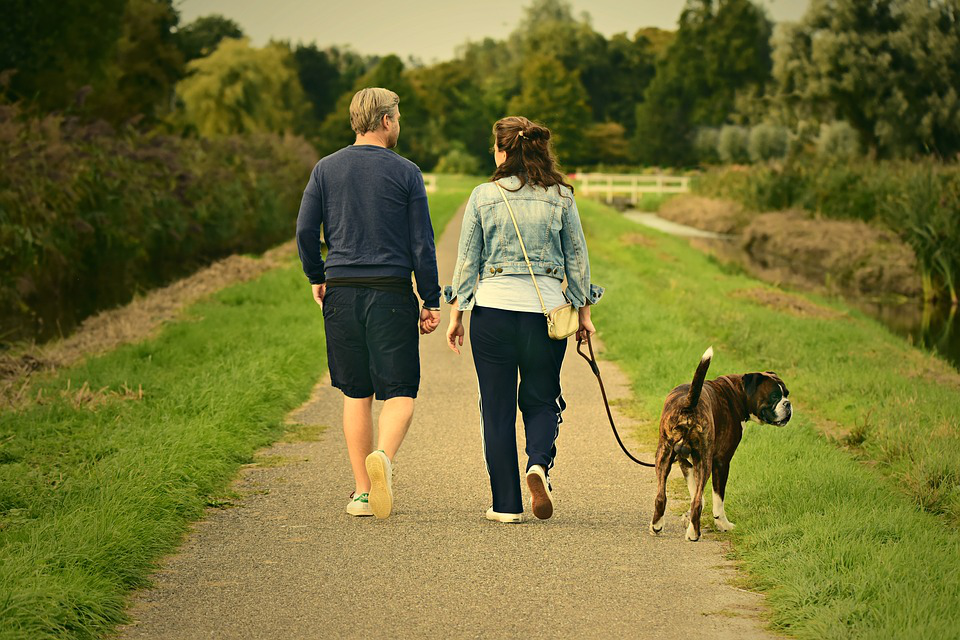

In [4]:
image = Image.open(img_file)
print(type(image))
print(image.size)
display(image)

In [5]:
image_data = open(img_file,"rb").read()

In [6]:
%%time
response = requests.post(f"http://{IP}:{PORT}/v1/vision/detection", files={"image":image_data})

CPU times: user 8.23 ms, sys: 5.74 ms, total: 14 ms
Wall time: 40.9 ms


In [7]:
response.status_code

200

In [8]:
response.json()

{'success': False, 'error': 'Incorrect api key'}

In [10]:
response.json()['error']

'Incorrect api key'

In [9]:
predictions = response.json()['predictions']

In [10]:
len(predictions)

3

In [11]:
def get_object_classes(predictions):
    """
    Get a list of the unique object classes predicted.
    """
    classes = [pred['label'] for pred in predictions]
    return set(classes)

In [12]:
classes = get_object_classes(predictions)
classes

{'dog', 'person'}

In [13]:
def format_confidence(confidence):
    """Takes a confidence from the API like 
       0.55623 and returne 55.6 (%).
    """
    return round(float(confidence)*100, 1)

format_confidence(0.55623)

55.6

In [14]:
def get_confidences_above_threshold(confidences, threshold):
    """Takes a list of confidences and returns those above a threshold."""
    return [val for val in confidences if val >= threshold]

get_confidences_above_threshold([0.2, 0.5, 0.6], 0.5)

[0.5, 0.6]

In [15]:
def get_object_instances(predictions, target):
    """
    Return the number of instances of a target class.
    """
    targets_identified = [format_confidence(pred['confidence']) for pred in predictions if pred['label'] == target]
    return targets_identified

In [16]:
get_object_instances(predictions, TARGET)

[100.0, 100.0]

In [17]:
def get_objects_summary(predictions):
    """
    Get a summary of the objects detected.
    """
    classes = get_object_classes(predictions)
    return {class_cat : get_object_instances(predictions, target=class_cat) 
            for class_cat in classes}

In [18]:
get_objects_summary(predictions)

{'dog': [99.7], 'person': [100.0, 100.0]}

## Display boxes

In [19]:
def draw_box(draw, prediction, text='', color=(255, 0, 0)):
    """Draw bounding box on image."""
    (left, right, top, bottom) = (prediction['x_min'], prediction['x_max'], prediction['y_min'], prediction['y_max'])
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=5, fill=color)
    if text:
        draw.text((left, abs(top-15)), text, fill=color)

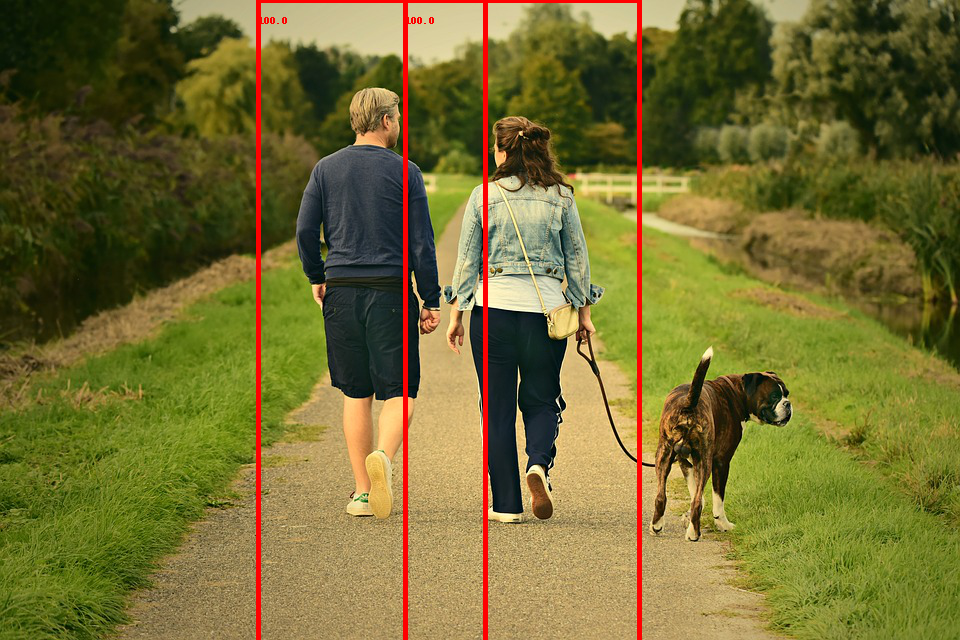

In [20]:
draw = ImageDraw.Draw(image)

for prediction in predictions:
    prediction_confidence = format_confidence(prediction['confidence'])
    if prediction['label'] == TARGET and prediction_confidence >= ATTR_CONFIDENCE:
        draw_box(draw, prediction, str(prediction_confidence))
        
    
display(image)

In [ ]:
image.save('boxed_img.jpg')

Issue for boxes -> https://forum.deepstack.cc/t/bounding-boxes-are-wrong/77/2